<a href="https://colab.research.google.com/github/s14t284/Seq2Seq_sample/blob/master/Seq2Seq_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Seq Sample

Seq2Seqのサンプル実装

- deep learning ライブラリでseq2seqを組むとき，どういう風に実装するかのサンプル
- 作成した動機
    - どのくらい，ライブラリはNNを抽象化しているかを知ってほしいため作成
    - ライブラリの使い方のサンプル（chainer以外の日本語サンプルはかなり少ない）
- 今回は，流行しているDLライブラリの1つであるpytorchで作成

## 必要なもの
- google colaboratory(導入は[ここ](https://tutorials.chainer.org/ja/01_Welcome_to_Chainer_Tutorial.html)がわかりやすい) or GPUが導入されたマシン
- データセット(今回は[ここ](http://www.jnlp.org/SNOW/T15)からダウンロード．日本語と英語の対訳コーパス)
    - Takumi Maruyama and Kazuhide Yamamoto. Simplified Corpus with Core Vocabulary. The 11th International Conference on Language Resources and Evaluation (LREC 2018)

In [1]:
!pip install torchtext==0.4.0
!pip install mecab-python3

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_path =  '/content/drive/My Drive/'  # このディレクトリがGoogleDriveのrootとしてマウントされている

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### データの整形
- データセットのエクセルファイルから，train, validation, testデータを作る
- 事前にGoogle Driveに"mt_dataset/"というディレクトリを作成し，その中にダウンロードしてきたXLSXファイルをアップロードしておく

In [0]:
import pandas as pd
df = pd.read_excel(data_path + 'mt_dataset/T15-2018.2.28.xlsx')
df = df.rename({'#日本語(原文)': 'Japanese', '#やさしい日本語': 'EasyJapanese', '#英語(原文)': 'English'}, axis=1)
df = df.loc[:, ['Japanese', 'EasyJapanese', 'English']]
df.loc[:int(len(df) * 0.8)].to_csv(data_path + 'mt_dataset/train.csv', index=False, header=False)
df.loc[int(len(df) * 0.8): int(len(df) * 0.9)].to_csv(data_path + 'mt_dataset/val.csv', index=False, header=False)
df.loc[int(len(df) * 0.9): ].to_csv(data_path + 'mt_dataset/test.csv', index=False, header=False)

In [4]:
df.head()

,Japanese,EasyJapanese,English
0,誰が一番に着くか私には分かりません。,誰が一番に着くか私には分かりません。,i can 't tell who will arrive first .
1,多くの動物が人間によって滅ぼされた。,多くの動物が人間によって殺された。,many animals have been destroyed by men .
2,私はテニス部員です。,私はテニス部員です。,i 'm in the tennis club .
3,エミは幸せそうに見えます。,エミは幸せそうに見えます。,emi looks happy .
4,この事実を心に留めておいて下さい。,この事実を覚えておいてください。,please bear this fact in mind .


## DataLoader
- データセットをよしなに扱ってくれるクラス
- 今回はpytorchで実装するが，tensorflowでもDataLoaderに似た概念は存在する
- pytorchでは，実装済みのDataLoaderが外部ライブラリで用意されている．今回は`torchtext`を利用する
    - 画像 : torchvision
    - 言語 : torchtext
    - DataLoaderを自力で1から書くのはつらみなので，出来るだけ既存のものに頼る．
        - ただし，torchtextはドキュメントが...

In [0]:
import time
import MeCab
import torchtext
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import spacy
from torchtext import data
from torchtext import datasets
from torchtext.vocab import FastText
from torchtext.vocab import GloVe
import matplotlib.pyplot as plt

In [0]:
m = MeCab.Tagger('-Owakati')
def jap_tokenizer(text):
    text = text.replace(' ', '')
    return [tok for tok in m.parse(text).split(' ')][:-1]

spacy_en = spacy.load('en')
def eng_tokenizer(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

### データの読み込み
- とても時間がかかるので注意
- Fieldはカラムの読み込みに使うオブジェクト．カラムごとにオブジェクトを作る
- TabularDatasetはcsv, tsv形式のファイルをデータセットとして読み込むことのできるクラス．
    - splitsメソッドはtrain, validation, testデータセットをそれぞれ別に読み込むことのできるデータセット

In [7]:
print('Fieldの定義')
japanese = data.Field(batch_first=True, sequential=True, tokenize=jap_tokenizer, init_token='<bos>', eos_token='<eos>')
easy_japanese = data.Field(batch_first=True, sequential=True, tokenize=jap_tokenizer, init_token='<bos>', eos_token='<eos>')
english = data.Field(batch_first=True, sequential=True, tokenize=eng_tokenizer, lower=True, init_token='<bos>', eos_token='<eos>')
print('データセットの読み込み')
train_data, val_data, test_data = data.TabularDataset.splits(
    path=data_path + 'mt_dataset/', train='train.csv', validation='val.csv', test='test.csv', format='csv',
    fields=[('JAP', japanese), ('EJAP', easy_japanese), ('ENG', english)]
)
print('語彙の選別と埋め込み表現との結びつけ')
japanese.build_vocab(train_data, min_freq=2, vectors=FastText(language='ja'))
easy_japanese.build_vocab(train_data, min_freq=2, vectors=FastText(language='ja'))
english.build_vocab(train_data, min_freq=2, vectors=GloVe())

Fieldの定義
データセットの読み込み
語彙の選別と埋め込み表現との結びつけ


In [8]:
vars(test_data[1])

{'EJAP': ['彼', 'に', 'は', 'する', '仕事', 'が', 'たくさん', 'ある', '。'],
 'ENG': ['he', 'had', 'a', 'lot', 'of', 'work', 'to', 'do', '.'],
 'JAP': ['彼', 'に', 'は', 'する', '仕事', 'が', 'たくさん', 'ある', '。']}

### Encoder-Decoderの定義

In [0]:
# teacher forcingを使わない
class Encoder(nn.Module):
    
    def __init__(self, embedding,
                           hidden_dim: int,
                           dropout_rate: float = 0.5):
        super(Encoder, self).__init__()
        vocab_size, embedding_dim = embedding.shape
        self._embedding = embedding
        self._hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=2)
        # self.lstm = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        """
        pytorchではnn.Moduleのforwardメソッドに順伝播を実装する
        """
        
        x = self.dropout(self._embedding[x])
        # Noneを隠れ層の値に当たる引数に挿入することで，0で初期化されたベクトルを隠れ層として挿入
        out, h = self.lstm(x, None)
        return out, h
    
class Decoder(nn.Module):
    
    def __init__(self, embedding,
                           hidden_dim: int,
                           itos: list,
                           dropout_rate: float = 0.5):
        super(Decoder, self).__init__()
        self._vocab_size, embedding_dim = embedding.shape
        self._embedding = embedding
        self._hidden_dim = hidden_dim
        self._itos = itos
        self._start_id = itos.index('<bos>')
        self._end_id = itos.index('<eos>')
        # self.lstm = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(hidden_dim, self._vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, x, hidden):
        input_ = self.dropout(self._embedding[x])
        y, hidden = self.lstm(input_, hidden)
        outs = self.softmax(self.linear(y))
        return  outs, hidden
    
    def generate(self, hidden, batch_size: int = 1):
        ids_ = torch.zeros(batch_size).long() + self._start_id
        sequence = []
        while all(ids_ != self._end_id):
            x = self._embedding[ids_]
            y, hidden = self.lstm(x.reshape(batch_size, 1, -1), hidden)
            out = self.linear(y)
            ids_ = torch.max(out, dim=2)[1]
            sequence.append([self._itos[i] for i in ids_])
        return [[s[i] for s in sequence if s[i] not in ['<pad>', '<eos>']] for i in range(batch_size)]


In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, input_ids, output_ids):
        batch_size, seq_len = output_ids.shape
        out, h = self.encoder(input_ids[:, 1:-1])
        out, h = self.decoder(output_ids[:, :-1], h)
        return out
    
    def generate(self, input_ids, start_id: int, end_id: int):
        with torch.no_grad():
            out, h = self.encoder(input_ids[:, 1:-1])
            sequences = self.decoder.generate(h, input_ids.shape[0])
        return sequences

### 学習，推論の定義

In [0]:
def train(model, iterator, optimizer, criterion):
    model.train()  # 学習するようにする
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        jap_seq = batch.JAP
        eng_seq = batch.ENG
        
        optimizer.zero_grad()
        output = model(jap_seq, eng_seq)
        loss = sum([criterion(output[:, i, :], eng_seq[:, i + 1])
                              for i in range(output.shape[1])])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()  # 学習しないようにする
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            jap_seq = batch.JAP
            eng_seq = batch.ENG
        
            output = model(jap_seq, eng_seq)
            loss = sum([criterion(output[:, i, :], eng_seq[:, i + 1])
                                    for i in range(output.shape[1])])
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### 学習の準備
- 今回は日本語 -> 英語の学習を行う
- 英日がしたかったら，EncoderとDecoderに与えるベクトルや語彙を逆にすれば良い

In [12]:
HIDDEN_DIM = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = Encoder(japanese.vocab.vectors.to(device), HIDDEN_DIM).to(device)
decoder = Decoder(english.vocab.vectors.to(device), HIDDEN_DIM, english.vocab.itos).to(device)
model = Seq2Seq(encoder, decoder).to(device)
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.1, 0.1)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(300, 512, num_layers=2, batch_first=True)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (lstm): LSTM(300, 512, num_layers=2, batch_first=True)
    (dropout): Dropout(p=0.5)
    (linear): Linear(in_features=512, out_features=3719, bias=True)
    (softmax): LogSoftmax()
  )
)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss(ignore_index=japanese.vocab.stoi['<pad>'])  # paddingのindexが来た時は学習しない
EPOCH_SIZE = 20
train_losses = []
valid_losses = []

In [14]:
train_iter = data.BucketIterator(
    train_data, batch_size=64,
    sort = True,
    sort_key=lambda x: len(x.JAP),
    device=torch.device('cuda' if torch.cuda.is_available else 'cpu'),
)
valid_iter = data.BucketIterator(
    val_data, batch_size=64,
    sort = True,
    sort_key=lambda x: len(x.JAP),
    device=torch.device('cuda' if torch.cuda.is_available else 'cpu'),
)

for epoch in range(EPOCH_SIZE):
    start = time.time()
    train_loss = train(model, train_iter, optimizer, criterion)
    valid_loss = evaluate(model, valid_iter, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print('epoch : {} time: {}'.format(epoch + 1, time.time() - start))
    print('train loss : {}'.format(train_loss), 'valid loss : {}'.format(valid_loss)) 

epoch : 1 time: 16.060424327850342
train loss : 44.00342381876498 valid loss : 39.28819277316709
epoch : 2 time: 16.31997275352478
train loss : 36.75070999681759 valid loss : 36.32865859888777
epoch : 3 time: 16.60804796218872
train loss : 33.41333230844321 valid loss : 34.74988966350314
epoch : 4 time: 16.545286655426025
train loss : 30.818086317933787 valid loss : 33.49225003206277
epoch : 5 time: 16.34868621826172
train loss : 28.68803939118553 valid loss : 32.724883912484856
epoch : 6 time: 16.304702520370483
train loss : 26.90197165096149 valid loss : 32.320398813561546
epoch : 7 time: 16.394033432006836
train loss : 25.377330382411092 valid loss : 32.09291395356384
epoch : 8 time: 16.44890522956848
train loss : 24.047314078663103 valid loss : 31.871727086320707
epoch : 9 time: 16.420554637908936
train loss : 22.937273424654343 valid loss : 31.699934198886535
epoch : 10 time: 16.435668468475342
train loss : 21.887554409404913 valid loss : 31.724830434292176
epoch : 11 time: 16.400

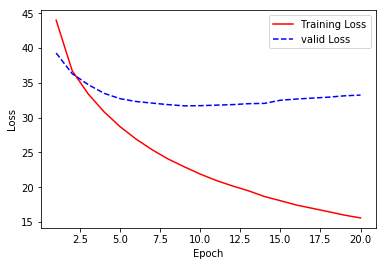

In [15]:
plt.plot(range(1, len(train_losses) + 1), train_losses, 'r-')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, 'b--')
plt.legend(['Training Loss', 'valid Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [16]:
test_iter = data.BucketIterator(
    test_data, batch_size=64,
    sort = True,
    sort_key=lambda x: len(x.JAP),
    device=torch.device('cuda' if torch.cuda.is_available else 'cpu'),
)
predicts  = []
answers = []
inputs = []
for test in test_iter:
    predicts += model.generate(test.JAP, 2, 3)
    answers += [[japanese.vocab.itos[i] for i in sentence_id if i not in [1, 2, 3]] for sentence_id in test.JAP]
    inputs += [[english.vocab.itos[i] for i in sentence_id if i not in [1, 2, 3]] for sentence_id in test.ENG]
answers = [answer for answer in answers]
predicts = [predict for predict in predicts]
inputs = [input_ for input_ in inputs]
for predict, answer, input_ in zip(predicts, answers, inputs):
    print(input_, predict, answer)

['this', 'is', 'a', 'splendid', 'house', '.'] ['the', 'boy', 'was', 'absent', 'from'] ['すばらしい', '家', 'です', 'ね', '。']
['i', 'wish', 'i', 'were', 'younger', '.'] ['i', "'", 'm', 'sorry', ','] ['もっと', '若けれ', 'ば', 'なぁ', '。']
['i', 'know', 'him', 'by', 'sight', '.'] ['i', "'", 'm', 'sorry', ','] ['見れ', 'ば', 'わかる', 'よ', '。']
['you', "'", 've', 'got', 'a', 'good', 'head', 'on', 'your', '<unk>', '.'] ['he', 'went', 'to', 'america', '.'] ['気', 'が', '<unk>', 'なあ', '。']
['don', "'", 't', 'make', 'fun', 'of', 'them', '.'] ['he', 'went', 'to', 'america', '.'] ['彼ら', 'を', '<unk>', 'な', '。']
['see', 'you', 'tomorrow', 'in', 'the', 'office', '.'] ['the', 'boy', 'observed', 'the', 'child'] ['明日', '会社', 'で', 'ね', '。']
['it', 'is', 'very', 'cold', 'today', '.'] ['i', 'have', 'seen', 'the', 'film'] ['今日', 'は', '大変', '寒い', '。']
['i', 'have', 'done', 'everything', 'i', 'could', 'do', '.'] ['he', 'went', 'to', 'america', '.'] ['手', 'は', '尽くし', 'た', '。']
['don', "'", 't', 'have', 'me', 'on', '!'] ['i', 'was',

In [0]:
torch.save(model.state_dict(), data_path + 'mt_dataset/model.pth')